  # About Dataset
The dataset is comprised of tab-separated files with phrases from the Rotten Tomatoes dataset. The train/test split has been preserved for the purposes of benchmarking, but the sentences have been shuffled from their original order. Each Sentence has been parsed into many phrases by the Stanford parser. Each phrase has a PhraseId. Each sentence has a SentenceId. Phrases that are repeated (such as short/common words) are only included once in the data.



The sentiment labels are:

0 - negative

1 - somewhat negative

2 - neutral

3 - somewhat positive

4 - positive

## Loading important Libraries

In [ ]:
import numpy as np 
import pandas as pd 
import os

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

In [ ]:
from keras.utils import to_categorical
import random
import tensorflow
tensorflow.random.set_seed(123)
random.seed(123)
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense,Dropout,Embedding,LSTM
from keras.callbacks import EarlyStopping
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.models import Sequential

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk import ngrams
lemmatizer = WordNetLemmatizer()
from bs4 import BeautifulSoup
import string, re, unicodedata

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import seaborn as sns
sns.set(color_codes=True)

from tqdm import tqdm

import matplotlib.pyplot as plt

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
plt.figure(figsize=(16,7))
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

<Figure size 1152x504 with 0 Axes>

## Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

train= pd.read_csv("/content/drive/MyDrive/FinalData/train.tsv", sep="\t")
test = pd.read_csv("/content/drive/MyDrive/FinalData/test.tsv", sep="\t")

train.shape,test.shape

((156060, 4), (66292, 3))

In [ ]:
train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [ ]:
train['Phrase'][0]

'A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .'

In [ ]:
train.loc[train['SentenceId'] == 1]

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
...,...,...,...,...
58,59,1,much,2
59,60,1,of a story,2
60,61,1,a story,2
61,62,1,story,2


In [ ]:
test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   PhraseId    156060 non-null  int64 
 1   SentenceId  156060 non-null  int64 
 2   Phrase      156060 non-null  object
 3   Sentiment   156060 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


In [ ]:
test.info( )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66292 entries, 0 to 66291
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   PhraseId    66292 non-null  int64 
 1   SentenceId  66292 non-null  int64 
 2   Phrase      66292 non-null  object
dtypes: int64(2), object(1)
memory usage: 1.5+ MB


In [ ]:
train.isnull().sum()

PhraseId      0
SentenceId    0
Phrase        0
Sentiment     0
dtype: int64

Sentiment Description

In [ ]:
train['sentiment_class'] = train['Sentiment'].map({0:'negative',1:'somewhat negative',2:'neutral',3:'somewhat positive',4:'positive'})
train.head()

,PhraseId,SentenceId,Phrase,Sentiment,sentiment_class
0,1,1,A series of escapades demonstrating the adage ...,1,somewhat negative
1,2,1,A series of escapades demonstrating the adage ...,2,neutral
2,3,1,A series,2,neutral
3,4,1,A,2,neutral
4,5,1,series,2,neutral


In [ ]:
dist=train.groupby(['Sentiment']).size()
dist

Sentiment
0     7072
1    27273
2    79582
3    32927
4     9206
dtype: int64

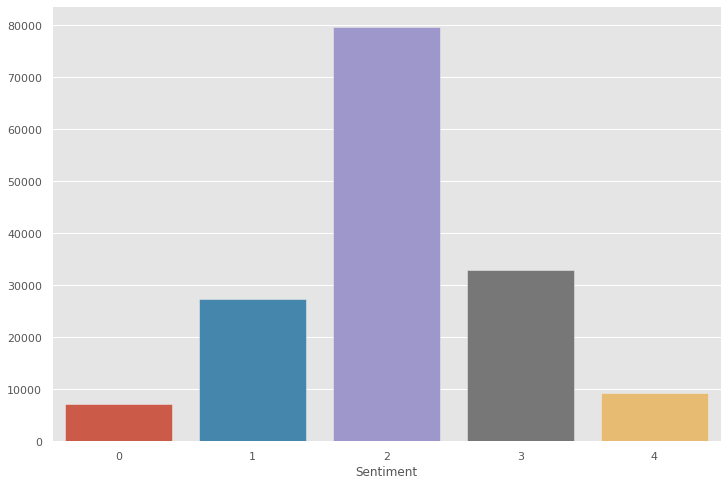

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(dist.keys(), dist.values);

Get percentages of each class

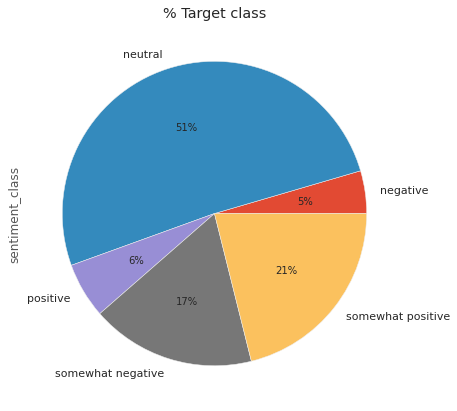

In [ ]:
((train.groupby('sentiment_class')['sentiment_class'].count()/train.shape[0])*100).plot(kind='pie',figsize=(7,7),title='% Target class', autopct='%1.0f%%')

Adding Phrase Length

In [ ]:
train['PhraseLength']=train['Phrase'].apply(lambda x: len(x))
train.sort_values(by='PhraseLength', ascending=False).head()

,PhraseId,SentenceId,Phrase,Sentiment,sentiment_class,PhraseLength
105155,105156,5555,... spiced with humor -LRB- ' I speak fluent f...,3,somewhat positive,283
43802,43803,2124,-LRB- City -RRB- reminds us how realistically ...,3,somewhat positive,279
145399,145400,7901,-LRB- Clooney 's -RRB- debut can be accused of...,3,somewhat positive,268
145400,145401,7901,-LRB- Clooney 's -RRB- debut can be accused of...,3,somewhat positive,266
85187,85188,4406,The film was produced by Jerry Bruckheimer and...,1,somewhat negative,266




Distribution of phrase length on each class


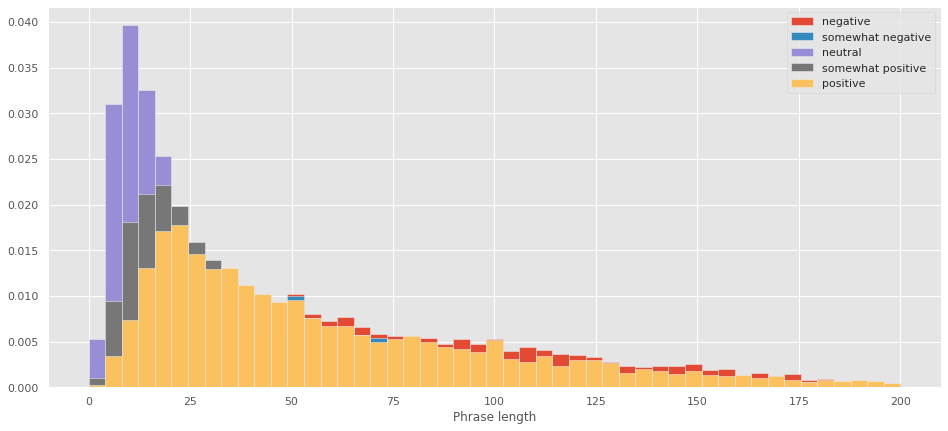

In [ ]:
plt.figure(figsize=(16,7))
bins=np.linspace(0,200,50)
plt.hist(train[train['sentiment_class']=='negative']['PhraseLength'],bins=bins,density=True,label='negative')
plt.hist(train[train['sentiment_class']=='somewhat negative']['PhraseLength'],bins=bins,density=True,label='somewhat negative')
plt.hist(train[train['sentiment_class']=='neutral']['PhraseLength'],bins=bins,density=True,label='neutral')
plt.hist(train[train['sentiment_class']=='somewhat positive']['PhraseLength'],bins=bins,density=True,label='somewhat positive')
plt.hist(train[train['sentiment_class']=='positive']['PhraseLength'],bins=bins,density=True,label='positive')
plt.xlabel('Phrase length')
plt.legend()
plt.show()

In [ ]:
from wordcloud import WordCloud, STOPWORDS 
stopwords = set(STOPWORDS)

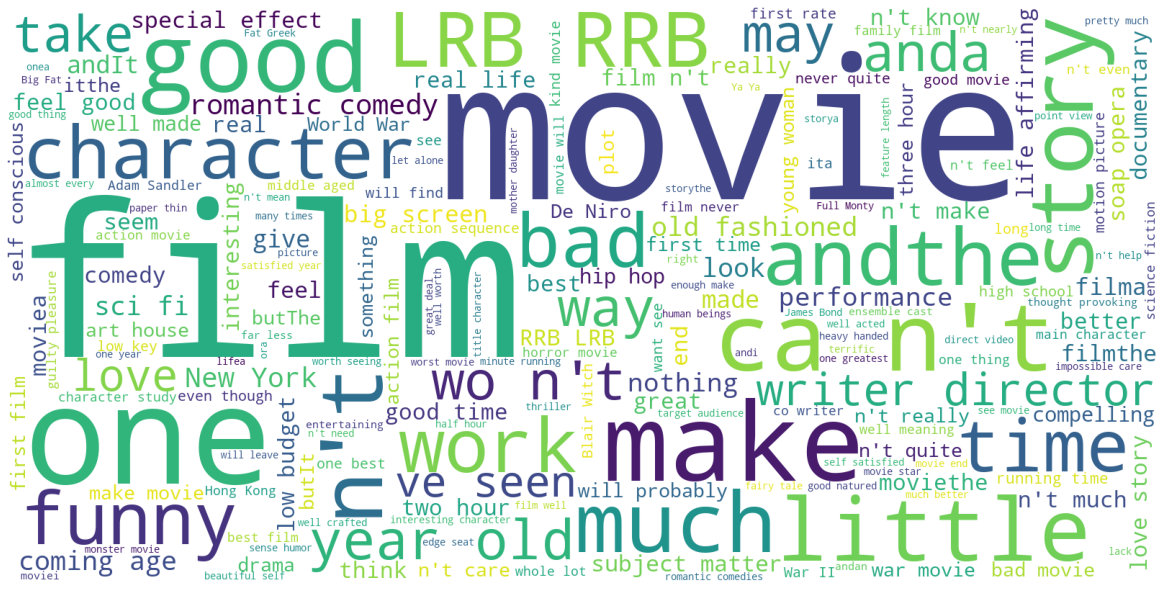

In [ ]:
word_cloud_common_words=[]  
for index, row in train.iterrows(): 
    word_cloud_common_words.append((row['Phrase'])) 
word_cloud_common_words

wordcloud = WordCloud(width = 1600, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 5).generate(''.join(word_cloud_common_words)) 
  
# plot the WordCloud image                        
plt.figure(figsize = (16, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

Word Frequency

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
text_list=[]  
for index, row in train.iterrows(): 
    text_list.append((row['Phrase'])) 
text_list

total_words=''.join(text_list)
total_words=word_tokenize(total_words)

In [ ]:
freq_words=FreqDist(total_words)
word_frequency=FreqDist(freq_words)

#10 common words
print(word_frequency.most_common(10))

[(',', 42002), ('the', 38912), ('of', 28400), ('and', 27915), ('a', 27404), ('to', 19493), ("'s", 15696), ('in', 11777), ('that', 10048), ('is', 8819)]


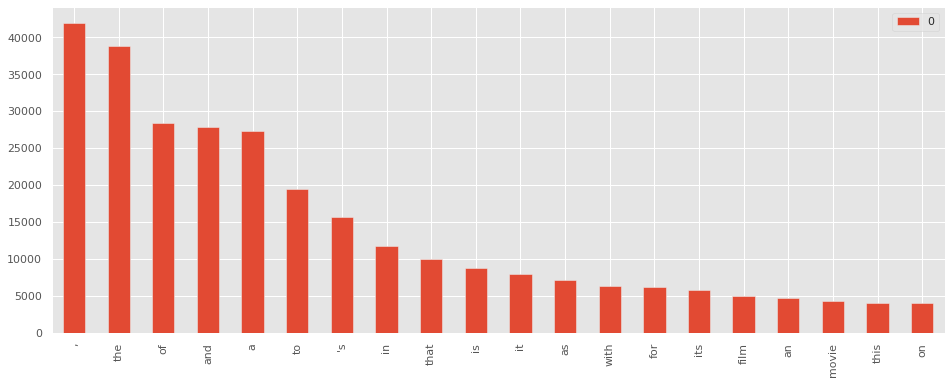

In [ ]:
pd.DataFrame(word_frequency,index=[0]).T.sort_values(by=[0],ascending=False).head(20).plot(kind='bar',figsize=(16,6),grid=True)



Common words used for negative sentiment


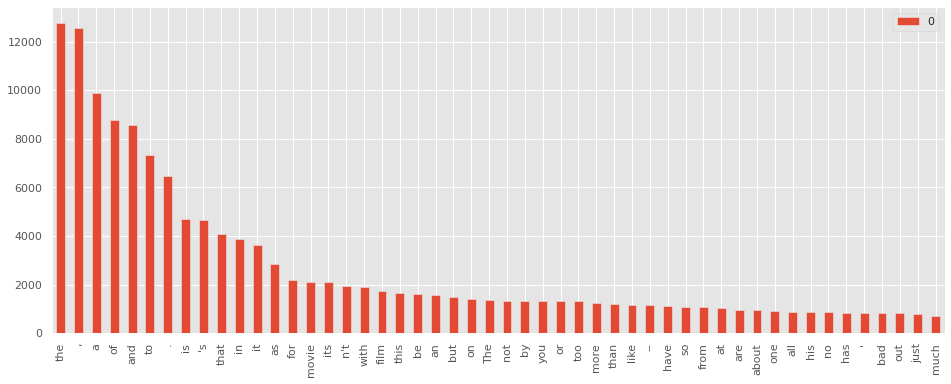

In [ ]:
neg_text_list=[]  
for index, row in train[train['Sentiment']<2].iterrows(): 
    neg_text_list.append((row['Phrase'])) 
neg_text_list

neg_total_words=' '.join(neg_text_list)
neg_total_words=word_tokenize(neg_total_words)

neg_freq_words=FreqDist(neg_total_words)
neg_word_frequency=FreqDist(neg_freq_words)

# visualize 
pd.DataFrame(neg_word_frequency,index=[0]).T.sort_values(by=[0],ascending=False).head(50).plot(kind='bar',figsize=(16,6),grid=True)

Common Words for Neutral Sentiment

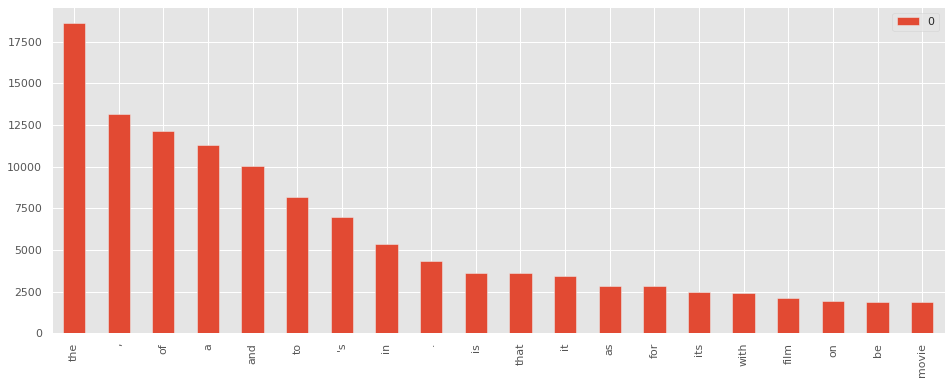

In [ ]:
neu_text_list=[]  
for index, row in train[train['Sentiment']==2].iterrows(): 
    neu_text_list.append((row['Phrase'])) 
neu_text_list

neu_total_words=' '.join(neu_text_list)
neu_total_words=word_tokenize(neu_total_words)

neu_freq_words=FreqDist(neu_total_words)
neu_word_frequency=FreqDist(neu_freq_words)

# visualize 
pd.DataFrame(neu_word_frequency,index=[0]).T.sort_values(by=[0],ascending=False).head(20).plot(kind='bar',figsize=(16,6),grid=True)



Common words used for positive sentiment


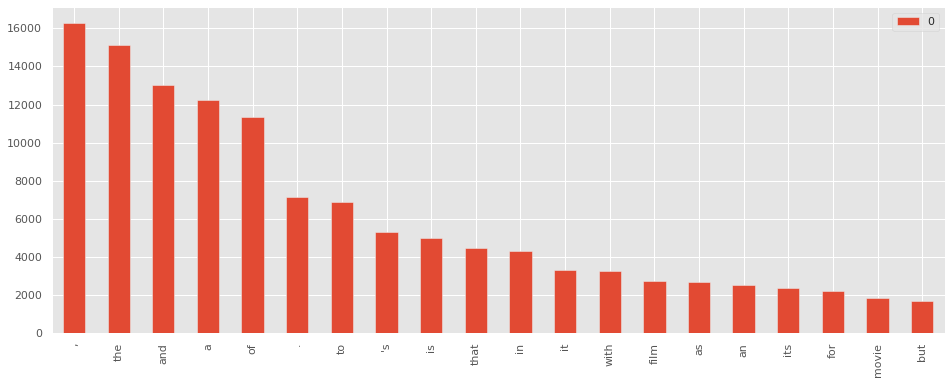

In [ ]:
pos_text_list=[]  
for index, row in train[train['Sentiment'] > 2].iterrows(): 
    pos_text_list.append((row['Phrase'])) 
pos_text_list

pos_total_words=' '.join(pos_text_list)
pos_total_words=word_tokenize(pos_total_words)

pos_freq_words=FreqDist(pos_total_words)
pos_word_frequency=FreqDist(pos_freq_words)

# visualize 
pd.DataFrame(pos_word_frequency,index=[0]).T.sort_values(by=[0],ascending=False).head(20).plot(kind='bar',figsize=(16,6),grid=True)



Common bigram words used for positive sentiment


In [ ]:
text="Tom and Jerry love mickey. But mickey dont love Tom and Jerry. What a love mickey is getting from these two friends"
bigram_frequency = FreqDist(ngrams(word_tokenize(text),3))
bigram_frequency.most_common()[0:5]

[(('Tom', 'and', 'Jerry'), 2),
 (('and', 'Jerry', 'love'), 1),
 (('Jerry', 'love', 'mickey'), 1),
 (('love', 'mickey', '.'), 1),
 (('mickey', '.', 'But'), 1)]

In [ ]:
text_list=[]  
for index, row in train.iterrows(): 
    text_list.append((row['Phrase'])) 
text_list

total_words=' '.join(text_list)
total_words=word_tokenize(total_words)

freq_words=FreqDist(total_words)
word_frequency=FreqDist(ngrams(freq_words,2))
word_frequency.most_common()[0:5]

[(('A', 'series'), 1),
 (('series', 'of'), 1),
 (('of', 'escapades'), 1),
 (('escapades', 'demonstrating'), 1),
 (('demonstrating', 'the'), 1)]

Remove Punctuation

In [ ]:
def remove_punctuation(text):
    return "".join([t for t in text if t not in string.punctuation])

train['Phrase']=train['Phrase'].apply(lambda x:remove_punctuation(x))

train.head()

,PhraseId,SentenceId,Phrase,Sentiment,sentiment_class,PhraseLength
0,1,1,A series of escapades demonstrating the adage ...,1,somewhat negative,188
1,2,1,A series of escapades demonstrating the adage ...,2,neutral,77
2,3,1,A series,2,neutral,8
3,4,1,A,2,neutral,1
4,5,1,series,2,neutral,6


In [ ]:
test['Phrase']=test['Phrase'].apply(lambda x:remove_punctuation(x))

Adding Phrase Length

In [ ]:
train['PhraseLength']=train['Phrase'].apply(lambda x: len(x))
train.sort_values(by='PhraseLength', ascending=False).head()

,PhraseId,SentenceId,Phrase,Sentiment,sentiment_class,PhraseLength
105155,105156,5555,spiced with humor LRB I speak fluent flatula...,3,somewhat positive,265
43802,43803,2124,LRB City RRB reminds us how realistically nuan...,3,somewhat positive,260
145399,145400,7901,LRB Clooney s RRB debut can be accused of bein...,3,somewhat positive,259
85187,85188,4406,The film was produced by Jerry Bruckheimer and...,1,somewhat negative,258
145400,145401,7901,LRB Clooney s RRB debut can be accused of bein...,3,somewhat positive,258




Distribution of phrase length on each class


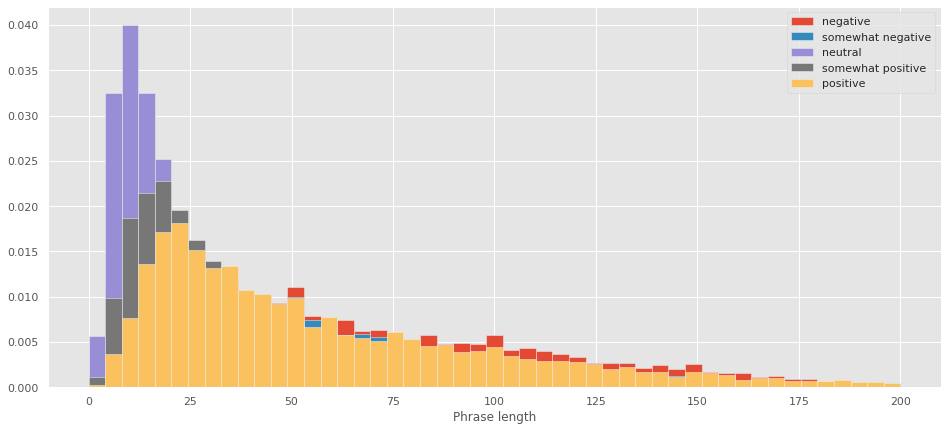

In [ ]:
plt.figure(figsize=(16,7))
bins=np.linspace(0,200,50)
plt.hist(train[train['sentiment_class']=='negative']['PhraseLength'],bins=bins,density=True,label='negative')
plt.hist(train[train['sentiment_class']=='somewhat negative']['PhraseLength'],bins=bins,density=True,label='somewhat negative')
plt.hist(train[train['sentiment_class']=='neutral']['PhraseLength'],bins=bins,density=True,label='neutral')
plt.hist(train[train['sentiment_class']=='somewhat positive']['PhraseLength'],bins=bins,density=True,label='somewhat positive')
plt.hist(train[train['sentiment_class']=='positive']['PhraseLength'],bins=bins,density=True,label='positive')
plt.xlabel('Phrase length')
plt.legend()
plt.show()

In [ ]:
from wordcloud import WordCloud, STOPWORDS 
stopwords = set(STOPWORDS)

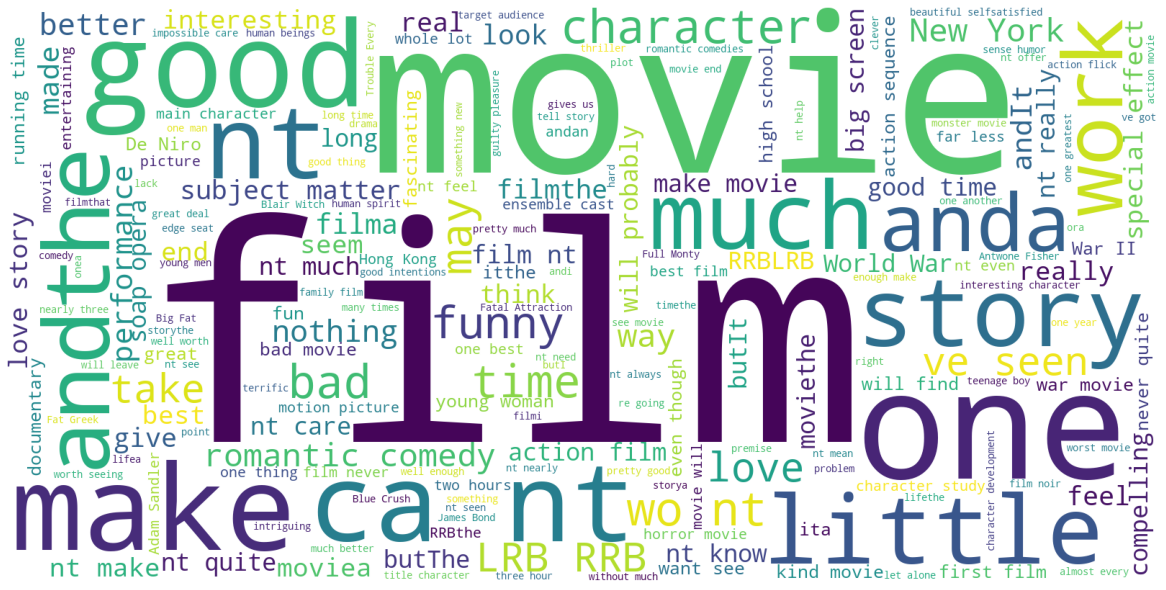

In [ ]:
word_cloud_common_words=[]  
for index, row in train.iterrows(): 
    word_cloud_common_words.append((row['Phrase'])) 
word_cloud_common_words

wordcloud = WordCloud(width = 1600, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 5).generate(''.join(word_cloud_common_words)) 
  
# plot the WordCloud image                        
plt.figure(figsize = (16, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

Word Frequency

In [ ]:
text_list=[]  
for index, row in train.iterrows(): 
    text_list.append((row['Phrase'])) 
text_list

total_words=''.join(text_list)
total_words=word_tokenize(total_words)

In [ ]:
freq_words=FreqDist(total_words)
word_frequency=FreqDist(freq_words)

#10 common words
print(word_frequency.most_common(10))

[('the', 39322), ('of', 28428), ('and', 27917), ('a', 27579), ('to', 19540), ('s', 14624), ('in', 11803), ('is', 10770), ('that', 10094), ('it', 8198)]


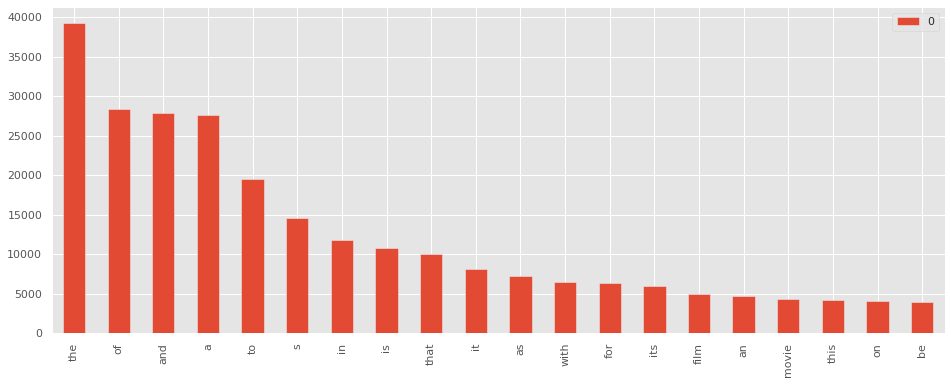

In [ ]:
pd.DataFrame(word_frequency,index=[0]).T.sort_values(by=[0],ascending=False).head(20).plot(kind='bar',figsize=(16,6),grid=True)



Common words used for negative sentiment


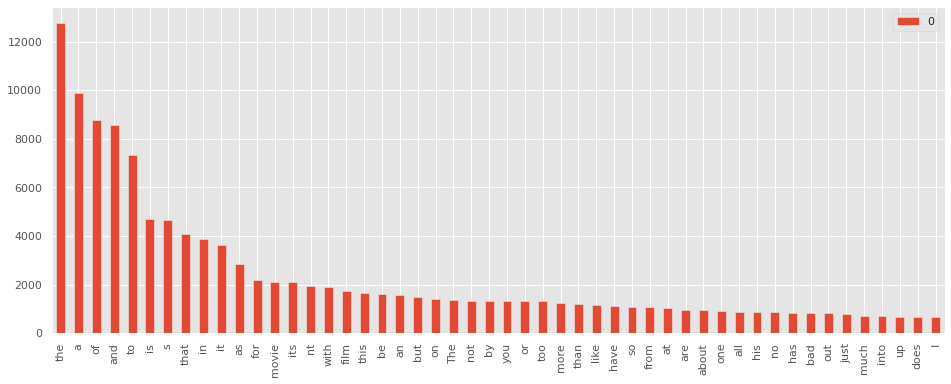

In [ ]:
neg_text_list=[]  
for index, row in train[train['Sentiment']<2].iterrows(): 
    neg_text_list.append((row['Phrase'])) 
neg_text_list

neg_total_words=' '.join(neg_text_list)
neg_total_words=word_tokenize(neg_total_words)

neg_freq_words=FreqDist(neg_total_words)
neg_word_frequency=FreqDist(neg_freq_words)

# visualize 
pd.DataFrame(neg_word_frequency,index=[0]).T.sort_values(by=[0],ascending=False).head(50).plot(kind='bar',figsize=(16,6),grid=True)

Common Words for Neutral Sentiment

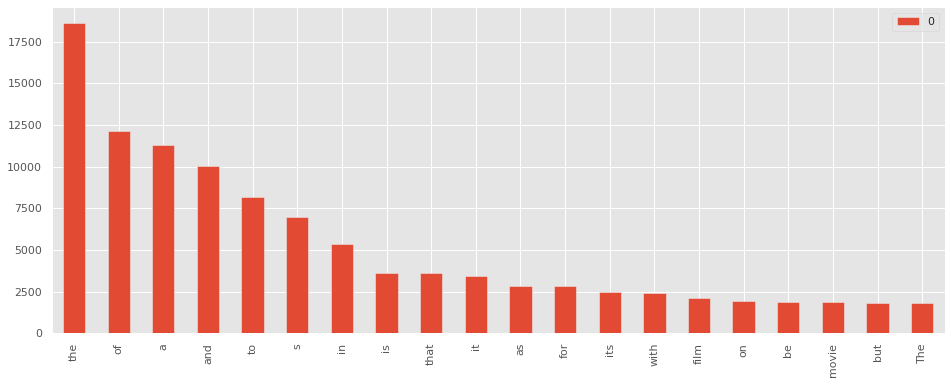

In [ ]:
neu_text_list=[]  
for index, row in train[train['Sentiment']==2].iterrows(): 
    neu_text_list.append((row['Phrase'])) 
neu_text_list

neu_total_words=' '.join(neu_text_list)
neu_total_words=word_tokenize(neu_total_words)

neu_freq_words=FreqDist(neu_total_words)
neu_word_frequency=FreqDist(neu_freq_words)

# visualize 
pd.DataFrame(neu_word_frequency,index=[0]).T.sort_values(by=[0],ascending=False).head(20).plot(kind='bar',figsize=(16,6),grid=True)



Common words used for positive sentiment


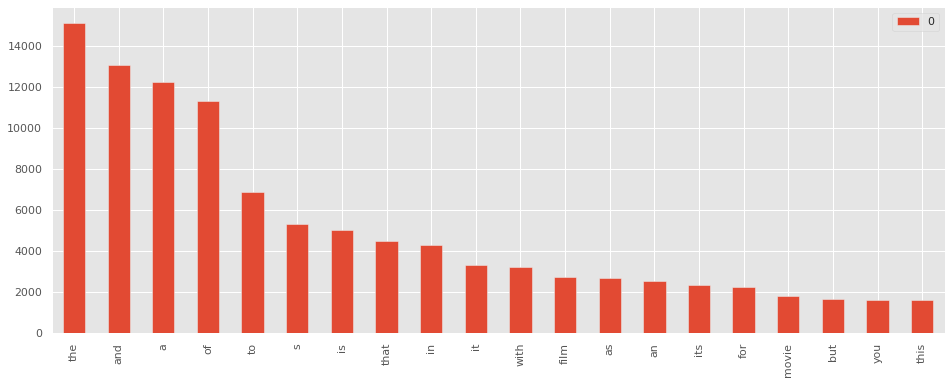

In [ ]:
pos_text_list=[]  
for index, row in train[train['Sentiment'] > 2].iterrows(): 
    pos_text_list.append((row['Phrase'])) 
pos_text_list

pos_total_words=' '.join(pos_text_list)
pos_total_words=word_tokenize(pos_total_words)

pos_freq_words=FreqDist(pos_total_words)
pos_word_frequency=FreqDist(pos_freq_words)

# visualize 
pd.DataFrame(pos_word_frequency,index=[0]).T.sort_values(by=[0],ascending=False).head(20).plot(kind='bar',figsize=(16,6),grid=True)



Common bigram words used for positive sentiment


In [ ]:
text_list=[]  
for index, row in train.iterrows(): 
    text_list.append((row['Phrase'])) 
text_list

total_words=' '.join(text_list)
total_words=word_tokenize(total_words)

freq_words=FreqDist(total_words)
word_frequency=FreqDist(ngrams(freq_words,2))
word_frequency.most_common()[0:5]

[(('A', 'series'), 1),
 (('series', 'of'), 1),
 (('of', 'escapades'), 1),
 (('escapades', 'demonstrating'), 1),
 (('demonstrating', 'the'), 1)]

# Function for cleaning the reviews, tokenize and lemmatize them.

In [ ]:
from nltk.corpus import stopwords
def clean_sentences(df):
    reviews = []

    for sent in tqdm(df['Phrase']):
        
        #remove html content
        review_text = BeautifulSoup(sent).get_text()
        
        #remove non-alphabetic characters
        review_text = re.sub("[^a-zA-Z]"," ", review_text)

    
        #tokenize the sentences
        words = word_tokenize(review_text.lower())
    
        #lemmatize each word to its lemma
        lemma_words = [lemmatizer.lemmatize(i) for i in words]

        #remove stop words
        stops = set(stopwords.words("english"))
        lemma_words = [w for w in lemma_words if not w in stops] #remove stop words
    
        reviews.append(lemma_words)

    return(reviews)



In [ ]:
train_sentences = clean_sentences(train)
test_sentences = clean_sentences(test)
print(len(train_sentences))
print(len(test_sentences))

100%|██████████| 66292/66292 [00:45<00:00, 1462.43it/s]

156060
66292


In [ ]:
from keras.utils import to_categorical

In [ ]:
target=train.Sentiment.values
y_target=to_categorical(target)
num_classes=y_target.shape[1]

In [ ]:
from sklearn.model_selection import train_test_split

## split into train and validation sets.

In [ ]:
X_train,X_val,y_train,y_val=train_test_split(train_sentences,y_target,test_size=0.2,stratify=y_target)

## Geting the no of unique words and max length of a review available in the list of cleaned reviews.

In [ ]:
unique_words = set()
len_max = 0

for sent in tqdm(X_train):
    
    unique_words.update(sent)
    
    if(len_max<len(sent)):
        len_max = len(sent)
        
print(len(list(unique_words)))
print(len_max)

100%|██████████| 124848/124848 [00:00<00:00, 570560.84it/s]

14720
31


## Actual tokenizer of keras and convert to sequences

In [ ]:
tokenizer = Tokenizer(num_words=len(list(unique_words)))
tokenizer.fit_on_texts(list(X_train))

#texts_to_sequences(texts)

    # Arguments- texts: list of texts to turn to sequences.
    #Return: list of sequences (one per text input).
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(test_sentences)

#padding done to equalize the lengths of all input reviews. LSTM networks needs all inputs to be same length.
#Therefore reviews lesser than max length will be made equal using extra zeros at end. This is padding.

X_train = sequence.pad_sequences(X_train, maxlen=len_max)
X_val = sequence.pad_sequences(X_val, maxlen=len_max)
X_test = sequence.pad_sequences(X_test, maxlen=len_max)

print(X_train.shape,X_val.shape,X_test.shape)

(124848, 31) (31212, 31) (66292, 31)


## Early stopping to prevent overfitting

In [ ]:
early_stopping = EarlyStopping(min_delta = 0.001, mode = 'max', monitor='val_acc', patience = 2)
callback = [early_stopping]

In [ ]:
#Model using Keras LSTM

#Multilayer Perceptron (MLP) for multi-class softmax classification:
#Let’s build what’s probably the most popular type of model in NLP at the moment: Long Short Term Memory network. 
#This architecture is specially designed to work on sequence data.
#It fits perfectly for many NLP tasks like tagging and text classification.
#It treats the text as a sequence rather than a bag of words or as ngrams.

#Here’s a possible model definition:

model=Sequential()
model.add(Embedding(len(list(unique_words)),300,input_length=len_max))
model.add(LSTM(128,dropout=0.5, recurrent_dropout=0.5,return_sequences=True))
model.add(LSTM(64,dropout=0.5, recurrent_dropout=0.5,return_sequences=False))
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.005),metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 31, 300)           4416000   
_________________________________________________________________
lstm (LSTM)                  (None, 31, 128)           219648    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 100)               6500      
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
Total params: 4,692,061
Trainable params: 4,692,061
Non-trainable params: 0
______________________________________________

## fit the model

In [ ]:
#This is done for learning purpose only. One can play around with different hyper parameters combinations
#and try increase the accuracy even more. For example, a different learning rate, an extra dense layer 
# before output layer, etc. Cross validation could be used to evaluate the model and grid search 
# further to find unique combination of parameters that give maximum accuracy. This model has a validation
#accuracy of around 66.5%
history=model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=6, batch_size=256, verbose=1, callbacks=callback)

Epoch 1/6
488/488 [==============================] - 372s 750ms/step - loss: 1.1204 - accuracy: 0.5524 - val_loss: 0.8663 - val_accuracy: 0.6463
Epoch 2/6
488/488 [==============================] - 364s 746ms/step - loss: 0.8090 - accuracy: 0.6682 - val_loss: 0.8327 - val_accuracy: 0.6591
Epoch 3/6
488/488 [==============================] - 365s 748ms/step - loss: 0.7273 - accuracy: 0.7011 - val_loss: 0.8428 - val_accuracy: 0.6601
Epoch 4/6
488/488 [==============================] - 364s 746ms/step - loss: 0.6801 - accuracy: 0.7167 - val_loss: 0.8737 - val_accuracy: 0.6629
Epoch 5/6
488/488 [==============================] - 364s 746ms/step - loss: 0.6481 - accuracy: 0.7285 - val_loss: 0.9044 - val_accuracy: 0.6556
Epoch 6/6
488/488 [==============================] - 364s 746ms/step - loss: 0.6313 - accuracy: 0.7316 - val_loss: 0.9002 - val_accuracy: 0.6624


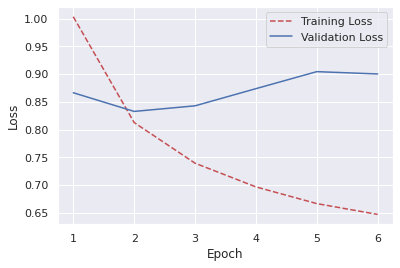

In [ ]:


# Create count of the number of epochs
epoch_count = range(1, len(history.history['loss']) + 1)

# Visualize learning curve. Here learning curve is not ideal. It should be much smoother as it decreases.
#As mentioned before, altering different hyper parameters especially learning rate can have a positive impact
#on accuracy and learning curve.
plt.plot(epoch_count, history.history['loss'], 'r--')
plt.plot(epoch_count, history.history['val_loss'], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
y_pred=model.predict_classes(X_test)

In [ ]:
y_pred

array([3, 3, 2, ..., 1, 1, 1])

In [ ]:
sub_file = pd.read_csv('/content/drive/MyDrive/FinalData/sampleSubmission.csv',sep=',')
sub_file.Sentiment=y_pred
sub_file.to_csv('Submission1.csv',index=False)

In [ ]:
model.save('fdfd.model')

INFO:tensorflow:Assets written to: fdfd.model/assets


In [ ]:
model.save('ai.h5')

In [ ]:
P=["I simply fail to understand how this film is so popular."," it's quite simply beyond me."," The only way I can explain it is that all the fans of King's short story found it very true to the spirit of the book, and voted 10 for that"," I really could not find anything worth my time in this film, and apart from a very good monologue from Freeman near the end, one or two good lines of dialog and the acting, there's really nothing in the whole film worth watching it for"," It's about hope"," and the director won't let us forget it, so it's repeated until the audience mumbles it in our sleep"," It's like this short, one-note story was written, and the author just didn't want to end it"," so he kept writing. and writing. until someone had the sense to break down the door and wrestle the pen from him yelling for the love of all that is holy, stop writing"," And I thank that faceless man for doing that, because it is undoubtedly the only reason the film was 142 minutes long, and not 284, or, dare I say it, 568"," The film simply drones on and on, scene after scene, containing nothing remotely interesting(but with excellent acting, mind you).","There's nothing good about this film except for the acting"," Just about all of it is great"," I can't really think of anything else to say"," I guess my dislike for the film stems from my hatred of King's writing.","I suppose it is possible for someone who is neutral on his works to enjoy this film"," I recommend this to fans of Stephen King, the actors and possibly Frank Darabont.","If you're not a fan of any of these people, I doubt you'd find this enjoyable."]
P=tokenizer.texts_to_sequences(P)
P=sequence.pad_sequences(P)
model.predict_classes(P)

array([2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 3, 2, 1, 1, 3, 3])

In [ ]:
S1=["I do not call this film a comedy movie","it is not a comedy movie"]
S1=tokenizer.texts_to_sequences(S1)
S1=sequence.pad_sequences(S1)
model.predict_classes(S1)

array([1, 2])

In [ ]:
from nltk.tokenize import sent_tokenize

In [ ]:
our_review="""I finally decided to see this film after reading good reviews and noting that this film ranks in IMDB's top ten list (currently #2). At the very least I disovered where all the noble people are: they're in prison!

The film is decent, but it certainly isn't what I would call great or extraordinary. There are good performances by Robbins and Freeman, but the pace of the movie is very slow and the cinematography is unremarkable. Characters are largely stereotypes, the story is somewhat formulaic (and sometimes ludicrous), and the noble prisoners vs wicked guards dichotomy is simplistic and unrealistic. I was also particularly annoyed at the narration, which always seemed to explain more than it needed to. As for the ending, I guess I was not as suprised as others since I did read the Stephen King novella many years ago. Still, given that the story takes place in a prison, you don't need to be a genius to guess part of it.

This movie reminds me of Dead Poets Society in terms of its tone and theme of uplifting the human spirit against a backdrop of despair. If that's your thing, you'll love the movie. It's not really my thing."""




S2=sent_tokenize(' '.join(our_review.split()))
S2=tokenizer.texts_to_sequences(S2)
S2=sequence.pad_sequences(S2)
M=model.predict_classes(S2)
average_rating=(sum(M)/len(M))
average_rating

2.1818181818181817

In [ ]:
L=['extraordinary','horrible','okay','nice','i did not understand anything','very good']
L=tokenizer.texts_to_sequences(L)
L=sequence.pad_sequences(L)
model.predict_classes(L)

array([3, 0, 2, 3, 2, 3])